## ICESat-2 Superelevation Finder 2000

Fill in the widget with the path to where the data will be stored. Then enter the width of the channel (measured externally)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import ee
import geemap
import logging
logging.getLogger('shapely.geos').setLevel(logging.CRITICAL)
from sliderule import icesat2
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import warnings
import rasterio as rio
from rasterio.features import shapes, rasterize
from ipywidgets import interact, widgets
from IPython.display import display
from utils import zoom_center, otsu, plot_comparison
from fiona import errors
import folium
import geopandas as gpd
import geemap.colormaps as gcm
import pandas as pd
from skimage.morphology import skeletonize, binary_dilation, skeletonize_3d   # noqa
from skimage.morphology import white_tophat, remove_small_objects
from skimage.morphology import disk  # noqa
from skimage import filters
import math
from shapely.geometry import Polygon
import numpy as np
os.environ["PLANET_API_KEY"] = "722017f6234b4160aa8d26fc6d39fa31"
import collections
collections.Callable = collections.abc.Callable
import plotly.express as px

try:
    ee.Initialize()
except Exception:
    ee.Authenticate()


#### Define all the functions we will need later...

In [15]:
def load_blank_map():
    # Bookkeeping
    # check to see if the files already exist in this directory to avoid redundant computation...
    global out_path
    out_path = os.path.join('../data')
    if os.path.isdir(out_path):
             os.system("rm -rf {}".format(out_path))
    os.makedirs(out_path, exist_ok=True)
    global data_path
    data_path = os.path.join(out_path, 'data')
    os.makedirs(data_path, exist_ok=True)
    global channel_outline_fname
    channel_outline_fname = os.path.join(out_path, 'CHANNELOUTLINE.shp')
    global full_data_gdf_fname
    full_data_gdf_fname = os.path.join(data_path, 'FULL_DATASET.feather')
    global gdf_watermask_fname
    gdf_watermask_fname = os.path.join(out_path, 'WATERMASK.shp')
    global out_tiff_fname
    out_tiff_fname = os.path.join(out_path,"MNDWI.tif")
    global out_mask_fname
    out_mask_fname = os.path.join(out_path,"OTSUMASK.tif")
    global skeleton_fname
    skeleton_fname = os.path.join(out_path,"SKEL.tif")
    global gdf_skel_fname
    gdf_skel_fname = os.path.join(out_path, "SKEL_VEC.shp")
    global cleaned_out_mask_fname
    cleaned_out_mask_fname = os.path.join(out_path,"CLEANED_WM.tif")
    global gdf_lines_fname
    gdf_lines_fname = os.path.join(out_path, "LINES.shp")
    global gdf_pts_fname
    gdf_pts_fname = os.path.join(out_path, "SKEL_PTS.shp")

    global Map
    Map = geemap.Map()
    #add planet background
    Map.add_planet_by_quarter(year=2021, quarter=2)
    return Map

    
def compute_mndwi():
    global roi
    roi = Map.draw_last_feature
    geemap.ee_to_shp(ee.FeatureCollection(roi), channel_outline_fname)
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2020-03-31').filterBounds(roi.geometry()).filterMetadata('CLOUD_COVER', 'less_than', 10).sort("CLOUD_COVER")
    im = collection.median()
    im = im.clip(roi.geometry())
    mndwi = im.normalizedDifference(['SR_B3', 'SR_B6'])
    return mndwi
    
def compute_threshold(mndwi):
    histogram = mndwi.reduceRegion(**{
      'reducer': ee.Reducer.histogram(255),
      'geometry': roi.geometry(),
      'scale': 30,
      'bestEffort': True
    })
    # Return the DN that maximizes interclass variance in B5 (in the region).
    threshold = otsu(histogram.get('nd'))
    print('threshold', threshold.getInfo())
    classA = mndwi.select('nd').gt(threshold) 
    channelmask = classA.updateMask(classA)
    return channelmask
    
def compute_vectors():
    downloader_prevec()
    from skimage.morphology import binary_closing, binary_dilation, binary_erosion
    from skimage.morphology import star, flood_fill
    mask = None
    footprint = disk(2)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with rio.open(out_mask_fname, 'r+') as src:
            kwds = src.profile
            image = src.read(1)
            #b_di = binary_dilation(image, footprint=footprint)
            rm_sh = remove_small_objects(image>0, image.shape[1])
            rm_sh = rm_sh.astype('int16')
            sk = skeletonize(rm_sh == 1)
            sk = sk.astype('int16')
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(rm_sh, mask=mask, transform=src.transform, connectivity=8)))
            geoms = list(results)
            gdf_watermask = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
            print(len(gdf_watermask.geometry))
            gdf_watermask = gdf_watermask.query('raster_val ==1')
            gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
            gdf_watermask['geometry'] = gdf_watermask.geometry.unary_union
            gdf_watermask = gdf_watermask[gdf_watermask.geometry.area == gdf_watermask.geometry.area.max()]
            print(type(gdf_watermask.geometry))
            gdf_watermask.to_file(gdf_watermask_fname)
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(sk, mask=mask, transform=src.transform, connectivity=8)))
            geoms = list(results)
            gdf_skel = gpd.GeoDataFrame.from_features(geoms, crs='epsg:4326')
            gdf_skel = gdf_skel.query('raster_val ==1')
            gdf_skel = gdf_skel[gdf_skel.geometry.geometry.area == gdf_skel.geometry.geometry.area.max()]
            gdf_skel.to_file(gdf_skel_fname)
            with rio.open(cleaned_out_mask_fname, 'w', **kwds) as src:
                src.write(rm_sh, 1)
            with rio.open(skeleton_fname, 'w', **kwds) as src:
                src.write(sk, 1)
    with rio.open(skeleton_fname, 'r', **kwds) as src:
        im = src.read(1)
        shapes1 = ((geom,value) for geom, value in zip(gdf_skel.geometry, gdf_skel['raster_val']))
        #shapes = dataframe.geometry.values
        varray = rasterize(shapes1,
                   out_shape=(im.shape[0], im.shape[1]),
                   transform=src.transform,
                   dtype=im.dtype)

        rc = np.where(varray == 1)
        interest = rio.transform.xy(src.transform, rc[0], rc[1], offset = 'center')
        df = pd.DataFrame()
        gdf_pts = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(interest[0], interest[1]), crs="epsg:4326")
        gdf_pts.to_file(gdf_pts_fname)

def fetch_icesat2():
    from sliderule import icesat2
    icesat2.init("icesat2sliderule.org", verbose = True)
    region = icesat2.toregion(gdf_watermask_fname)[0]
    parms = {"poly": region, "srt": 4, "cnf": icesat2.CNF_SURFACE_HIGH} #"atl08_class": "atl08_ground"}
    # make request
    rsps = icesat2.atl03sp(parms)
    # analyze response
    df_sr = pd.DataFrame(rsps)
    print(len(df_sr))
    warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
    from scipy.stats import zscore
    if len(df_sr) == 0:
        raise RuntimeError("No available granules")
        
    # Basic processing of ICESAT-2 photons
    #in order to pick out each track, we group by several variables `'rgt', 'cycle', 'track', 'pair'`. 
    #Each track gets a unique identifier. If any track has less than 5 points returned, skip it. (this can be adjusted depending on need). 
    #We save it as a .feather file for faster read/write speeds. I've instituted some light filtering by taking out
    # any points that lie greater than 3 std devs above the mean. Feel free to tweak this...
    
    gdf = gpd.GeoDataFrame(df_sr, geometry = df_sr.geometry)
    g = gdf.groupby(['rgt', 'cycle', 'track', 'pair'])
    p = 1
    df_list = []
    for k, v in g:
        v['lon'] = v.geometry.x
        v['lat'] = v.geometry.y
        v['UID'] = p
        ##### zscore filtering ####
        v['zscore'] = np.abs(zscore(v["height"]))
        v = v[v['zscore']<3]
        ##### zscore filtering ####
        v = gpd.GeoDataFrame(v, geometry = gpd.points_from_xy(x = v['lon'], y = v['lat'], crs="epsg:4326"))
        if len(v) > 5:
            df_list.append(v)
            v.reset_index().to_feather(os.path.join(data_path,'LINE_{}.feather'.format(p)))
            p += 1
    full_data_gdf = pd.concat(df_list)
    full_data_gdf.crs = "epsg:4326"
    full_data_gdf.to_feather(full_data_gdf_fname)

    
def add_simple_lines(Map):
    from shapely.geometry import Point, LineString
    full_data_gdf = gpd.read_feather(full_data_gdf_fname)
    gdf_skel = gpd.read_file(gdf_skel_fname)
    gdf_lines = full_data_gdf.groupby(['UID'])['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist())
    gdf_lines_list = []
    for i in gdf_lines.geometry.bounds.iterrows():
        gdf_lines_list.append(gpd.GeoDataFrame({"UID":i[0],"geometry":LineString([Point(i[1]['minx'], i[1]['miny']), Point(i[1]['maxx'], i[1]['maxy'])])}, index=[0]))
    gdf_lines_sm = pd.concat(gdf_lines_list)
    gdf_lines_sm.crs = "epsg:4326"
    gdf_lines_sm.to_file(gdf_lines_fname)
    Map.addLayer(geemap.geopandas_to_ee(gdf_lines_sm), {}, 'ICESAT-2 Tracks')
    
def angle_threshold(angle, width):
    full_data_gdf = gpd.read_feather(full_data_gdf_fname)
    gdf_lines_sm = gpd.read_file(gdf_lines_fname)
    gdf_skel = gpd.read_file(gdf_pts_fname)
    inty = gpd.overlay(gdf_lines_sm, gdf_skel, 'intersection')
    inty = inty.to_crs("epsg:3857")
    inty['geometry'] = inty.geometry.buffer(int(width)//5)
    inty = inty.to_crs("epsg:4326")
    inty = inty.explode(index_parts=False)
    gdf_ov = gpd.overlay(inty, gdf_skel, how='intersection')
    import math
    join_df = inty.sjoin(gdf_ov, how="left")
    import numpy as np
    ang_list = []
    uid_list = []
    for k, i in zip(join_df.index, join_df.iterrows()):

        try:
            uid = i[1].index
            arr = i[1]['geometry']
            polygon = Polygon(i[1]['geometry'].exterior.coords)

            gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
            ov2 = gpd.overlay(gdf, gdf_skel, "intersection")
            bbox = ov2.geometry.bounds
            minx_bb = bbox.iloc[0, :]['minx']
            miny_bb = bbox.iloc[0, :]['miny']
            maxx_bb = bbox.iloc[0, :]['maxx']
            maxy_bb = bbox.iloc[0, :]['maxy']

            cl_angle = math.degrees(math.atan2(maxy_bb-miny_bb, maxx_bb-minx_bb))

            ri = i[1]['index_right']
            bbox = gdf_ov.bounds.iloc[int(ri)]

            ls_angle = math.degrees(math.atan2(bbox[3]-bbox[1], bbox[2]-bbox[0]))

            ang = (np.abs((((((cl_angle - ls_angle) % 360) + 540) % 360) - 180)))
            if ang > angle:
                ang_list.append(ang)
                uid_list.append(k)
                print(k, ang)

        except (AttributeError, ValueError):
            print('Multi or NaN')


    ang_df=pd.DataFrame(ang_list, index=uid_list, columns = ["ANGLE"])
    ang_df.index.name = 'UID'

    list_of_indexes = ang_df.index.unique()

    good_angle = full_data_gdf.loc[full_data_gdf['UID'].isin(list_of_indexes.values)]
    vis_params_goodangle_ee = {
        'color': '#FFC0CB'  
    }
    good_angle_ee = geemap.geopandas_to_ee(good_angle)
    Map.addLayer(good_angle_ee, vis_params_goodangle_ee, 'Thresholded Angles')
    Map.centerObject(good_angle_ee.geometry())
    
def downloader_prevec():
    keep_running = True
    while (keep_running):
        for scale in range(30, 150, 10):
            print("Trying to export at {} meters/pixel...".format(scale)) 
            if os.path.isfile(out_tiff_fname) is False:
                geemap.ee_export_image(mndwi, out_tiff_fname, scale=scale, region=roi.geometry())
            else:
                keep_running = False
                break   
    print("downloaded at {} m/pixel".format(scale))
    keep_running = True
    while (keep_running):
        for scale in range(30, 150, 10):
            print("Trying to export at {} meters/pixel...".format(scale)) 
            if os.path.isfile(out_mask_fname) is False:
                geemap.ee_export_image(channelmask, out_mask_fname, scale=scale, region=roi.geometry())
            else:
                keep_running = False
                break   
    print("downloaded at {} m/pixel".format(scale))

### Draw an ROI on the map
the ROI can be a square, circle, or polygon and can be drawn in the interactive map below

In [16]:
Map = load_blank_map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

#### Compute MNDWI in GEE backend
the drawn ROI and the MNDWI raster are saved to the local path.
Them, use Otsu's Method inside GEE to offload computation
_note: if the export fails, change the scale parameter in the `geemap.ee_export_image()` function_

In [17]:
mndwi = compute_mndwi() 
channelmask = compute_threshold(mndwi)
palette = list(gcm.palettes.hsv.n08)   
Map.addLayer(mndwi, {'palette': palette}, "MNDWI")
Map.addLayer(channelmask, {}, 'Channel Mask')
Map.centerObject(channelmask)

Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/data/CHANNELOUTLINE.shp
threshold -0.05657363297258675


#### Channel Raster Mask Processing for Obtaining Centerline and Buffer Vectors
three separate steps occur here:
1. Convert the binary water mask to a skeleton (1px wide representation). To do this, the image needs to be clead up a bit. to do this I run the remove small holes operation from sci-kit image. This basically runs a filter with a specified size over the region and removes any coherent feature (connected values > 0) smaller than the specified size. I use half of the image length as a simple size value and it seems to work well.
2. Polygonize the cleaned watermask to a dataframe and save it locally
3. Quality check before querying data from SlideRule

In [18]:
compute_vectors()
Map.addLayer(geemap.shp_to_ee(gdf_watermask_fname), {'color': '#FFC0CB'}, 'Cleaned Watermask Vector')
Map.addLayer(geemap.shp_to_ee(gdf_skel_fname), {'color': 'ff0000', 'width': 2}, 'Centerline')
Map

Trying to export at 30 meters/pixel...
Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/data/MNDWI.tif
Trying to export at 40 meters/pixel...
downloaded at 40 m/pixel
Trying to export at 30 meters/pixel...
Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/IS2_Water_SE/data/OTSUMASK.tif
Trying to export at 40 meters/pixel...
downloaded at 40 m/pixel
2
<class 'geopandas.geoseries.GeoSeries'>


Map(bottom=66747.0, center=[-2.4999693163742798, -75.49942016601564], controls=(WidgetControl(options=['positi…

#### Query SlideRule

[From the website:](http://icesat2sliderule.org/)

>SlideRule is a server-side framework implemented in C++/Lua that provides REST APIs for processing science data and returning results. This enables researchers and other data systems to have low-latency access to generated data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to the official ICESat-2 datasets hosted by the NSIDC. While its web services can be accessed by any http client (e.g. curl), a Python client is provided that makes it easier to interact with SlideRule.
> 

If the polygon looks good we will just pass the water polygon to sliderule and ask for high confidence photons flagged as inland water by the processing algorithm. This method works well and cuts down on excess calls.

_note: don't worry about the WARNINGs and INFO readouts with 0 points returned, it's normal with the verbose = True_

In [19]:
fetch_icesat2()

ERROR:sliderule.icesat2:HTTP Request Error: Request-URI Too Large
ERROR:sliderule.icesat2:HTTP Request Error: Request-URI Too Large
INFO:sliderule.icesat2:Identified 53 resources to process
INFO:sliderule.icesat2:Allocating 21 workers across 7 processing nodes
INFO:sliderule.icesat2:0 points returned for ATL03_20190504225440_05600308_004_01.h5 (1 out of 53 resources)
INFO:sliderule.icesat2:11247 points returned for ATL03_20181104073510_05600108_004_01.h5 (2 out of 53 resources)
INFO:sliderule.icesat2:2061 points returned for ATL03_20190803183421_05600408_004_01.h5 (3 out of 53 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190203031503_05600208_004_01.h5 (4 out of 53 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190304015103_10020208_004_01.h5 (5 out of 53 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190602213037_10020308_004_01.h5 (6 out of 53 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20191102141414_05600508_004

25076


#### Simplify the lines for display 

In [20]:
add_simple_lines(Map)
Map

Map(bottom=532758.0, center=[-2.803827159118122, -75.41393280029298], controls=(WidgetControl(options=['positi…

### Intersect and Buffer Repeatedly...
Here we do a series of intersections and buffers to determine the "direction" of the river centerline in places were ICESAT-2 track data exist. 

In [24]:
width = 170
full_data_gdf = gpd.read_feather(full_data_gdf_fname)
gdf_lines_sm = gpd.read_file(gdf_lines_fname) #simple lines
gdf_skel = gpd.read_file(gdf_skel_fname) #centerline
gdf_pts = gpd.read_file(gdf_pts_fname) #centerline XY pts

#change all dataframes to projected coordinate system for buffering
gdf_pts = gdf_pts.to_crs('epsg:3857')
gdf_skel = gdf_skel.to_crs('epsg:3857')
gdf_lines_sm = gdf_lines_sm.to_crs('epsg:3857')
full_data_gdf = full_data_gdf.to_crs('epsg:3857')

# intersect the simple lines with the centerline to determine which lines to buffer
inty = gpd.overlay(gdf_lines_sm, gdf_skel, 'intersection')

# buffer the intersection to two times the channel width
inty['geometry'] = inty.geometry.buffer(int(width)//2)
inty = inty.explode(index_parts=False) # make each buffer its own geometry

# add the intersections to the map
Map.addLayer(geemap.geopandas_to_ee(inty), {}, 'inty')

#intersect the formerly intersected and buffered points with the points of the centerline
gdf_ov = gpd.overlay(inty, gdf_pts, how='intersection', keep_geom_type=False)

# Add the layer
Map.addLayer(geemap.geopandas_to_ee(gdf_ov.to_crs("epsg:4326")), {}, 'buffs')

#intersect the formerly intersected and buffered points with the simplified icesat-2 lines
gdf_ov2 = gpd.overlay(inty, gdf_lines_sm, how='intersection', keep_geom_type=False)

### Angle Thresholding
A line is fit to the centerline points within a 2 channel width buffer of the intersection points and the angle between the lines (centerline segment and icesat-2 track) is computed. If that angle is less than a user-supplied threshold, drop the line from analysis.

In [25]:
angle = 70
join_df = inty.sjoin(gdf_ov2, how="left")
import numpy as np
ang_list = []
uid_list = []
for k, i in zip(join_df.UID_1, join_df.iterrows()):
    try:
        uid = i[1].UID_1
        arr = i[1]['geometry']
        polygon = Polygon(i[1]['geometry'].exterior.coords)
        gdf = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[polygon])
        ov2 = gpd.overlay(gdf_pts, gdf, "intersection", keep_geom_type=False)
        minx = ov2.geometry.x.min()
        maxx = ov2.geometry.x.max()
        miny = ov2.geometry.y.min()
        maxy = ov2.geometry.y.max()
        cl_angle = math.degrees(math.atan2(maxy-miny, maxx-minx))
        #print(k, cl_angle)
        temp = gdf_ov2.query("UID_1=={}".format(i[1]['index_right']))
        #print(temp)
        bbox = temp.geometry.bounds
        minx_bb = bbox.iloc[0, :]['minx']
        miny_bb = bbox.iloc[0, :]['miny']
        maxx_bb = bbox.iloc[0, :]['maxx']
        maxy_bb = bbox.iloc[0, :]['maxy']
        ls_angle = math.degrees(math.atan2(maxy_bb-miny_bb, maxx_bb-minx_bb))
        if (np.abs(cl_angle-ls_angle) > angle):
            ang_list.append(np.abs(cl_angle-ls_angle))
            uid_list.append(k)
        
    except IndexError:
        pass


ang_df=pd.DataFrame(ang_list, index=uid_list, columns = ["ANGLE"])
ang_df.index.name = 'UID'
ang_df.index.drop_duplicates()
ang_df = ang_df[~ang_df.index.duplicated(keep='first')]
list_of_indexes = ang_df.index.unique()

### Visualize the Data

We're going to use plotly's mapbox function to plot these points, it handles them _really_ well natively, I think because it's built on java?

Plotly's functionality allows us to hover over the lines of interest.

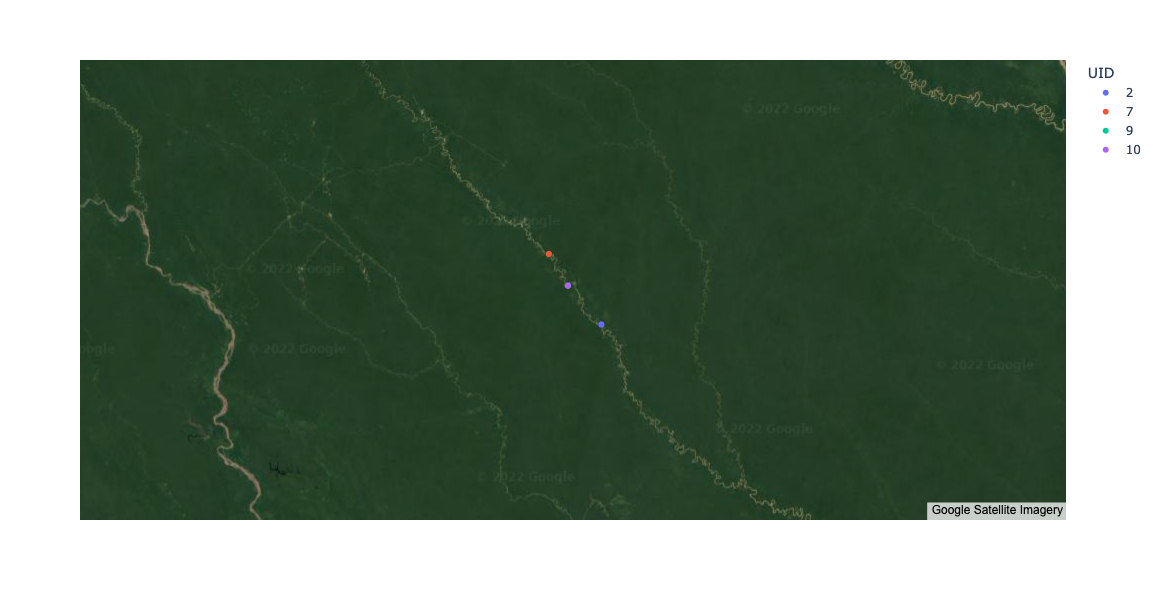

In [28]:
good_angle = full_data_gdf.loc[full_data_gdf['UID'].isin(list_of_indexes.values)]
good_angle.UID = good_angle.UID.astype(str)
fig = px.scatter_mapbox(good_angle, lat="lat", lon="lon", hover_data=["UID"], color='UID') #color='se', hover_data=["uid"])
fig.update_layout(
    mapbox_style="white-bg", height=600,
    mapbox_layers=[
        {
            "below": "traces",
            "minzoom": 5,
            "maxzoom": 24,
            "sourcetype": "raster",
            "sourceattribution": "Google Satellite Imagery",
            "source": [
                "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"
            ]
        }])

In [34]:
temp_df = good_angle.query("UID == {}".format(track))


time
2018-11-04 07:35:57.746053672     2
2018-11-04 07:35:57.746153676     2
2018-11-04 07:35:57.746553676     2
2018-11-04 07:35:57.746653676     2
2018-11-04 07:35:57.746853644     2
                                 ..
2021-01-29 16:34:01.742305376    10
2021-01-29 16:34:01.742305376    10
2021-01-29 16:34:01.742305376    10
2021-01-29 16:34:01.742305376    10
2021-01-29 16:34:01.742305376    10
Name: UID, Length: 9640, dtype: object

### Visualizing a single track

supply the UID from the line of interest and see the plot!

_some caveats: I have plotted a linear regression line automatically in the plots, this is more of a guide than anything else. Additionally, I've plotted latitude on the x-axis, this may have som undesired geometric effects. If this is the case, use the timestamp of the collected photon (next cell down). The seaborn `regplot()` won't work with timeseries data, however._

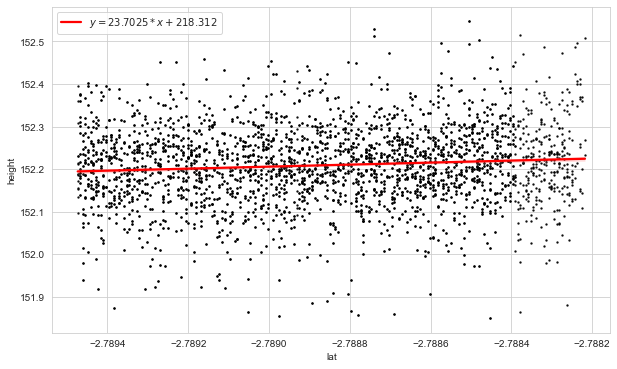

In [36]:
import seaborn as sns; sns.set_style("whitegrid")
from scipy import stats
track = 10
good_angle.UID = good_angle.UID.astype(int)
temp_df = good_angle.query("UID == {}".format(track))
temp_df.UID = temp_df.UID.astype('int')
fig, ax = plt.subplots(1, figsize=(10, 6))
slope, intercept, r_value, pv, se = stats.linregress(temp_df['lat'], temp_df['height'])
sns.regplot(data=temp_df, x="lat", y="height", scatter_kws={"color": "black", "s":2}, line_kws={"color": "red", 'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)}, ax=ax)
plt.legend()
plt.show()


### Can we do better? Using Robust Regression

Seaborn's statistical plotting tools allows for a robust regression. Unfortuantely, it can be somewhat slow.

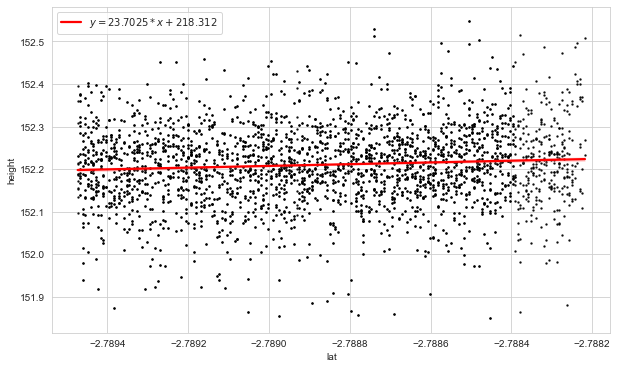

In [37]:
import seaborn as sns; sns.set_style("whitegrid")
from scipy import stats

temp_df = good_angle.query("UID == {}".format(track))
temp_df.UID = temp_df.UID.astype('int')
fig, ax = plt.subplots(1, figsize=(10, 6))
slope, intercept, r_value, pv, se = stats.linregress(temp_df['lat'], temp_df['height'])
sns.regplot(data=temp_df, x="lat", y="height", robust=True, scatter_kws={"color": "black", "s":2}, line_kws={"color": "red", 'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)}, ax=ax)
plt.legend()
plt.show()

### Keep Going! Random Sample Consensus (RANSAC) Regression

We can use a RANSAC regressor, which iteratively fits a model (in this case, y=mx+b) and is robust to outliers.
> _Random sample consensus (RANSAC) is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates. Therefore, it also can be interpreted as an outlier detection method._ — Wikipedia

0.009099763368905944 0.0312494179723232


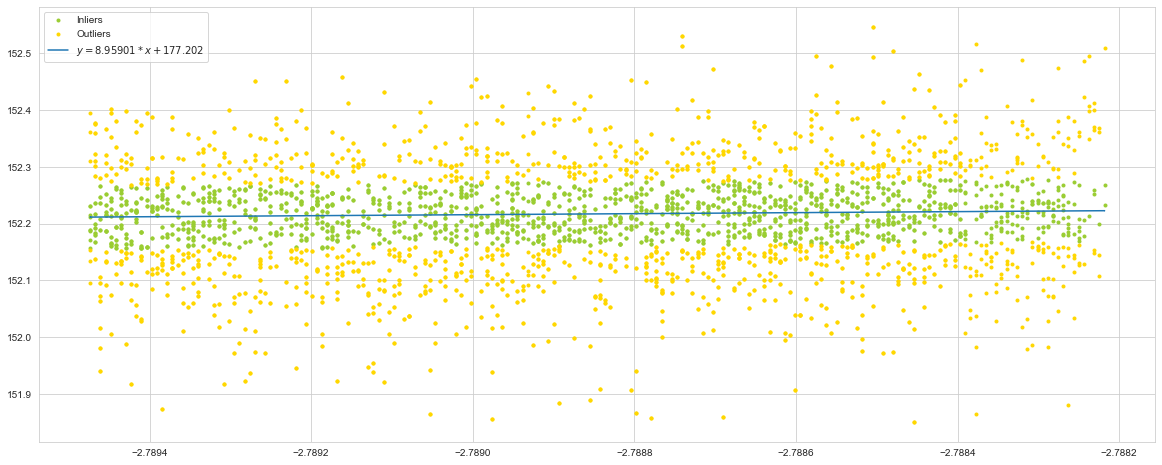

In [38]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

# Data
# Proper shape
x = temp_df.lat
y = temp_df.height
x, y = np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)

# Fit linear model with RANSAC algorithm

ransac = linear_model.RANSACRegressor(min_samples=10, max_trials=10000000)
ransac.fit(x, y)

# Estimated coefficients
m, c = float(ransac.estimator_.coef_), float(ransac.estimator_.intercept_)
#         print("\nm={:.3f}, c={:.3f}".format(m, c))

# R^2 & RMSE statistics
inlier_mask = ransac.inlier_mask_
x_accpt, y_accpt = x[inlier_mask], y[inlier_mask]
y_predict = m * x_accpt + c
R2 = r2_score(y_accpt, y_predict)
RMSE = np.sqrt(mean_squared_error(y_accpt, y_predict))
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
lw = 4
plt.scatter(
    x[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    x[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(x_accpt, y_predict, label='$y=%3.7s*x+%3.7s$'%(m, c))#, x="lat", y="height", robust=True, scatter_kws={"color": "black", "s":2}, line_kws={"color": "red", 'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)}, ax=ax)
plt.legend()
plt.show()

#### Using the timestamp index..

We have plotted using latitude on the x-axis so far. This works with good angles ( > ~70°) but might have undesirable geometric effects... SlideRule returns each photon with a timestamp index (very useful on their part). One could using this as well, though fitting a regression won't be as easy due to the temporal index

<AxesSubplot:xlabel='time', ylabel='height'>

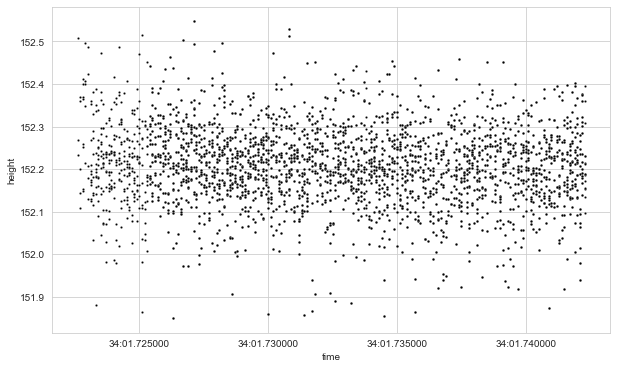

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(data=temp_df, x=temp_df.index, y="height", color='black', s=5, ax=ax)

To save the data as csv. just run this cell

In [ ]:
filename = "myfilename.csv"
full_data_gdf.to_file(os.path.join(out_path, filename))